In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    Exited — факт ухода клиента

## Подготовка данных


In [3]:
pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 923.3 kB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
import numpy as np
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Churn.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
data.head(20)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [8]:
data.duplicated().sum()

0

Удалим лишнюю информацию.

In [9]:
data = data.drop(['RowNumber', 'CustomerId','Surname'], axis = 1)

In [10]:
data = data.rename(columns = {'CreditScore':'credit_score',
                            'Geography' : 'geography',
                            'Gender' : 'gender',
                            'Age' : 'age',
                            'Tenure' : 'tenure',
                            'Balance' : 'balance',
                            'NumOfProducts':'num_of_products',
                            'HasCrCard':'has_credit_card',
                            'IsActiveMember':'is_active_member',
                            'EstimatedSalary':'estimated_salary',
                            'Exited':'exited',})

In [11]:
columns = ['geography', 'gender']

for column in columns:
    data[column] = data[column].str.lower()

Есть пропуски в столбце Tenure, заполним медианым значением.

In [12]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

<ipython-input-13-1b08c3b0bcf3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method = 'spearman'), annot = True);


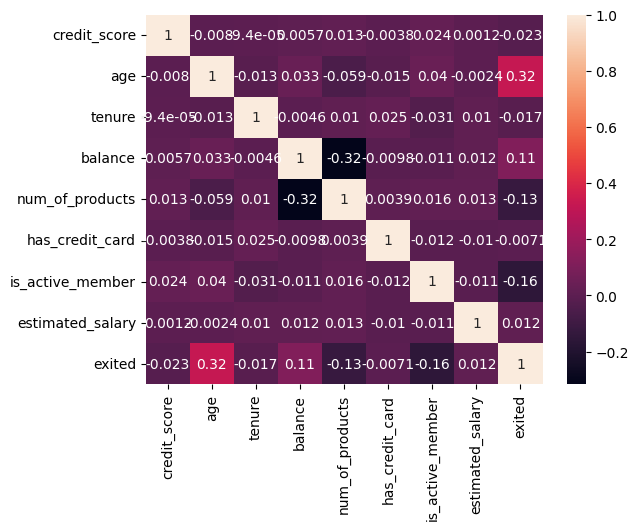

In [13]:
sns.heatmap(data.corr(method = 'spearman'), annot = True);

Корреляция независимых переменных не выявлена

In [14]:
data_train, data_test = train_test_split(data, test_size = 0.4, random_state = 88)
data_test, data_valid = train_test_split(data_test, test_size = 0.5, random_state = 88)

In [15]:
features_train = data_train.drop(['exited'], axis = 1)
target_train = data_train['exited']
features_test = data_test.drop(['exited'], axis = 1)
target_test = data_test['exited']
features_valid = data_valid.drop(['exited'], axis = 1)
target_valid = data_valid['exited']

In [16]:
print(data.shape)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(10000, 11)
(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


In [17]:
ce_one_hot = ce.OneHotEncoder(cols = ['geography', 'gender'])
features_train = ce_one_hot.fit_transform(features_train, target_train)
features_valid = ce_one_hot.transform(features_valid, target_valid)
features_test = ce_one_hot.transform(features_test, target_test)

In [18]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [19]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

0    0.7935
1    0.2065
Name: exited, dtype: float64


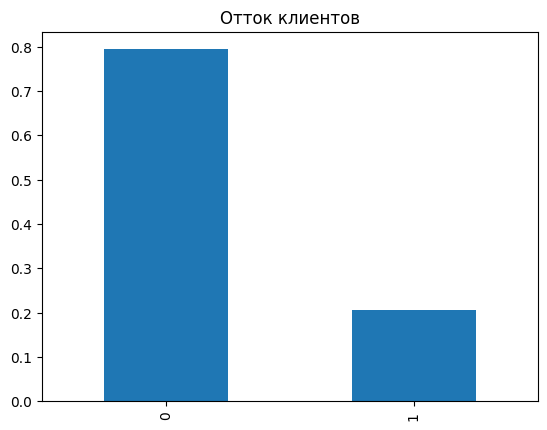

In [20]:
class_frequency = target_train.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar', title = 'Отток клиентов');

Наблюдается дисбаланс классов, 20% клиентов ушло.

In [21]:
def roc_auc(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('AUC-ROC:', (roc_auc_score(target_valid, probabilities_one_valid)))
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

## Борьба с дисбалансом

### Взвешивание классов

#### Логистическая регрессия

F1: 0.49956178790534617
AUC-ROC: 0.7760890624999999


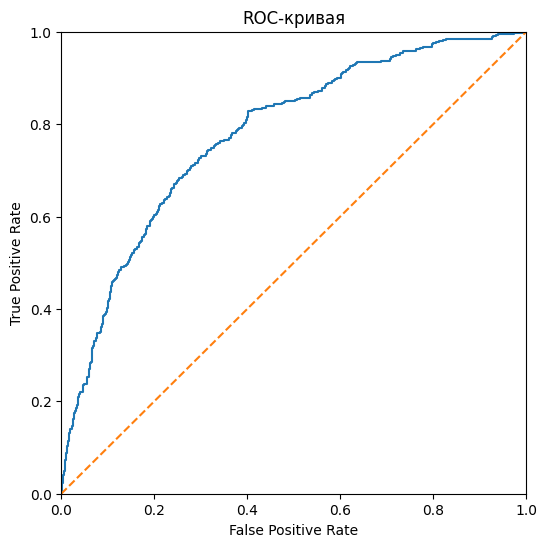

In [22]:
log_model = LogisticRegression(random_state = 88, solver = 'liblinear', class_weight = 'balanced')
log_model.fit(features_train, target_train)
predicted_valid = log_model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

roc_auc(log_model, features_valid, target_valid)

#### Дерево решений

In [23]:
%time

best_depth = 0
best_result = 0
for depth in range(1, 31):
    tree_model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 88, max_depth = depth, criterion = 'gini')
    tree_model.fit(features_train, target_train)
    predictions = tree_model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    print('Глубина дерева', depth,'F1-мера', result)
    if result > best_result:
        best_depth = depth
        best_result = result


print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
Глубина дерева 1 F1-мера 0.48170731707317077
Глубина дерева 2 F1-мера 0.5004965243296922
Глубина дерева 3 F1-мера 0.5225603357817419
Глубина дерева 4 F1-мера 0.5026985350809562
Глубина дерева 5 F1-мера 0.5753114382785957
Глубина дерева 6 F1-мера 0.5649717514124294
Глубина дерева 7 F1-мера 0.5646630236794171
Глубина дерева 8 F1-мера 0.5514636449480642
Глубина дерева 9 F1-мера 0.5361010830324909
Глубина дерева 10 F1-мера 0.5269230769230769
Глубина дерева 11 F1-мера 0.524557956777996
Глубина дерева 12 F1-мера 0.506
Глубина дерева 13 F1-мера 0.500539374325782
Глубина дерева 14 F1-мера 0.489795918367347
Глубина дерева 15 F1-мера 0.4912689173457509
Глубина дерева 16 F1-мера 0.48
Глубина дерева 17 F1-мера 0.4746600741656366
Глубина дерева 18 F1-мера 0.455470737913486
Глубина дерева 19 F1-мера 0.4681933842239186
Глубина дерева 20 F1-мера 0.45219638242894056
Глубина дерева 21 F1-мера 0.4609375
Глубина дерева 22 F1-мера 0.464698

AUC-ROC: 0.83363984375


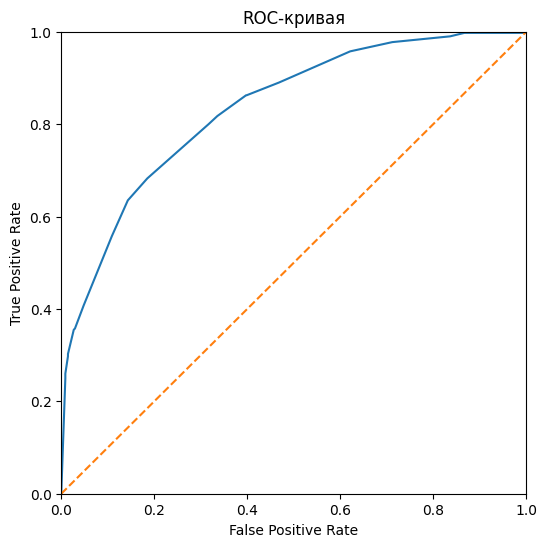

In [24]:
tree_model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 88, max_depth = 5, criterion = 'gini')
tree_model.fit(features_train, target_train)
predictions = tree_model.predict(features_valid)

roc_auc(tree_model, features_valid, target_valid)

#### Случайный лес

In [25]:
%%time

best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 151, 10):
    for depth in range (1, 21):
        forest_model = RandomForestClassifier(class_weight = 'balanced', random_state = 88, max_depth = depth, criterion = 'gini', n_estimators = est)
        forest_model.fit(features_train, target_train)
        predictions = forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        print('Количество деревьев', est, 'Глубина', depth, 'F1-мера', result)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print("F1-мера:", best_result, "Количество деревьев:", best_est, "При глубине каждого дерева:", best_depth)


Количество деревьев 10 Глубина 1 F1-мера 0.5132420091324201
Количество деревьев 10 Глубина 2 F1-мера 0.5392561983471074
Количество деревьев 10 Глубина 3 F1-мера 0.5354645354645355
Количество деревьев 10 Глубина 4 F1-мера 0.5772357723577236
Количество деревьев 10 Глубина 5 F1-мера 0.5636363636363637
Количество деревьев 10 Глубина 6 F1-мера 0.5835095137420718
Количество деревьев 10 Глубина 7 F1-мера 0.5825242718446602
Количество деревьев 10 Глубина 8 F1-мера 0.5812917594654788
Количество деревьев 10 Глубина 9 F1-мера 0.5846867749419954
Количество деревьев 10 Глубина 10 F1-мера 0.5598991172761666
Количество деревьев 10 Глубина 11 F1-мера 0.5733157199471598
Количество деревьев 10 Глубина 12 F1-мера 0.5683355886332883
Количество деревьев 10 Глубина 13 F1-мера 0.5258620689655172
Количество деревьев 10 Глубина 14 F1-мера 0.5177514792899408
Количество деревьев 10 Глубина 15 F1-мера 0.5388127853881278
Количество деревьев 10 Глубина 16 F1-мера 0.5152
Количество деревьев 10 Глубина 17 F1-мера 0.5

AUC-ROC: 0.8553734375


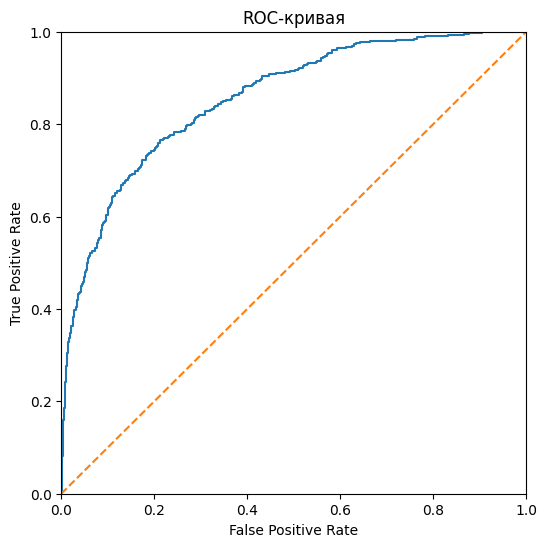

In [26]:
forest_model = RandomForestClassifier(class_weight = 'balanced', random_state = 88, max_depth = 9, criterion = 'gini', n_estimators = 90)
forest_model.fit(features_train, target_train)
predictions = forest_model.predict(features_valid)

roc_auc(forest_model, features_valid, target_valid)

### Увеличение выборки

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=88)

    return features_upsampled, target_upsampled

In [28]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [29]:
target_upsampled.value_counts(normalize = True)

1    0.510034
0    0.489966
Name: exited, dtype: float64

In [30]:
target_upsampled.shape

(9717,)

In [31]:
features_upsampled.shape

(9717, 13)

#### Логистическая регрессия

F1 мера: 0.49659863945578236
AUC-ROC: 0.7761671875


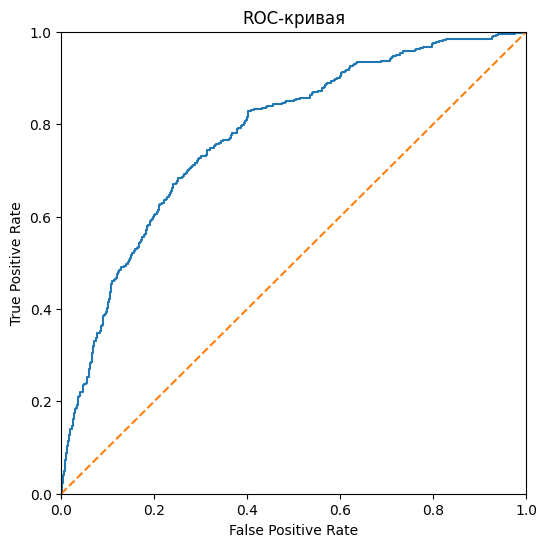

In [32]:
log_model = LogisticRegression(random_state = 88, solver = 'liblinear')
log_model.fit(features_upsampled, target_upsampled)
predicted_valid = log_model.predict(features_valid)
print("F1 мера:", f1_score(target_valid, predicted_valid))

roc_auc(log_model, features_valid, target_valid)

#### Дерево решений

In [33]:
%time

best_depth = 0
best_result = 0
for depth in range(1, 31):
    tree_model = DecisionTreeClassifier(random_state = 88, max_depth = depth, criterion = 'gini')
    tree_model.fit(features_upsampled, target_upsampled)
    predictions = tree_model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    print('Глубина дерева', depth, 'F1-мера', result)
    if result > best_result:
        best_depth = depth
        best_result = result


print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Глубина дерева 1 F1-мера 0.48170731707317077
Глубина дерева 2 F1-мера 0.5004965243296922
Глубина дерева 3 F1-мера 0.5225603357817419
Глубина дерева 4 F1-мера 0.5026985350809562
Глубина дерева 5 F1-мера 0.5753114382785957
Глубина дерева 6 F1-мера 0.5649717514124294
Глубина дерева 7 F1-мера 0.5550660792951542
Глубина дерева 8 F1-мера 0.5538752362948961
Глубина дерева 9 F1-мера 0.5329719963866304
Глубина дерева 10 F1-мера 0.5252140818268316
Глубина дерева 11 F1-мера 0.5235294117647059
Глубина дерева 12 F1-мера 0.5030181086519115
Глубина дерева 13 F1-мера 0.5010570824524313
Глубина дерева 14 F1-мера 0.48863636363636365
Глубина дерева 15 F1-мера 0.48346636259977194
Глубина дерева 16 F1-мера 0.4896969696969697
Глубина дерева 17 F1-мера 0.46601941747572817
Глубина дерева 18 F1-мера 0.45707070707070707
Глубина дерева 19 F1-мера 0.45707070707070707
Глубина дерева 20 F1-мера 0.45728643216080406
Глубина дерева 21 F1-мера 0.45918367346

AUC-ROC: 0.83363984375


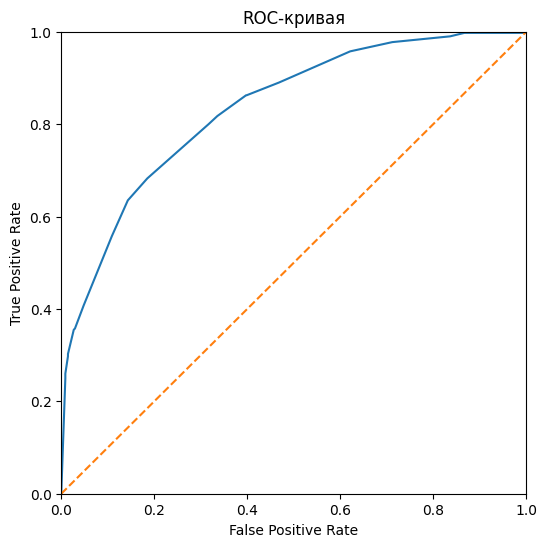

In [34]:
tree_model = DecisionTreeClassifier(random_state = 88, max_depth = 5, criterion = 'gini')
tree_model.fit(features_upsampled, target_upsampled)
predictions = tree_model.predict(features_valid)

roc_auc(tree_model, features_valid, target_valid)

#### Случайный лес

In [35]:
%%time

best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 151, 10):
    for depth in range (1, 21):
        new_forest_model = RandomForestClassifier(random_state = 88, max_depth = depth, criterion = 'gini', n_estimators = est)
        new_forest_model.fit(features_upsampled, target_upsampled)
        predictions = new_forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        print('Количество деревьев', est, 'Глубина', depth, 'F1-мера', result)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print("F1-мера:", best_result, "Количество деревьев:", best_est, "При глубине каждого дерева:", best_depth)


Количество деревьев 10 Глубина 1 F1-мера 0.4728682170542635
Количество деревьев 10 Глубина 2 F1-мера 0.5269343780607247
Количество деревьев 10 Глубина 3 F1-мера 0.548
Количество деревьев 10 Глубина 4 F1-мера 0.5694980694980695
Количество деревьев 10 Глубина 5 F1-мера 0.5669291338582677
Количество деревьев 10 Глубина 6 F1-мера 0.5816649104320336
Количество деревьев 10 Глубина 7 F1-мера 0.5740932642487048
Количество деревьев 10 Глубина 8 F1-мера 0.5964546402502607
Количество деревьев 10 Глубина 9 F1-мера 0.5605095541401275
Количество деревьев 10 Глубина 10 F1-мера 0.5674217907227616
Количество деревьев 10 Глубина 11 F1-мера 0.5792474344355758
Количество деревьев 10 Глубина 12 F1-мера 0.5700712589073633
Количество деревьев 10 Глубина 13 F1-мера 0.5672009864364981
Количество деревьев 10 Глубина 14 F1-мера 0.5648854961832063
Количество деревьев 10 Глубина 15 F1-мера 0.5447368421052632
Количество деревьев 10 Глубина 16 F1-мера 0.5361930294906166
Количество деревьев 10 Глубина 17 F1-мера 0.56

AUC-ROC: 0.859871875


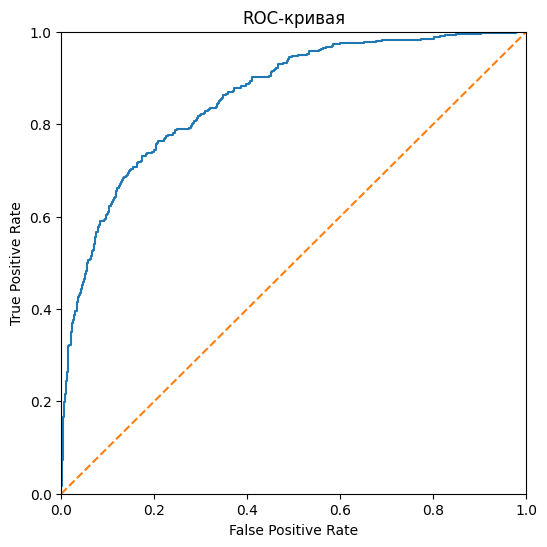

In [36]:
forest_model = RandomForestClassifier(random_state = 88, max_depth = 10, criterion = 'gini', n_estimators = 110)
forest_model.fit(features_upsampled, target_upsampled)
predictions = forest_model.predict(features_valid)

roc_auc(forest_model, features_valid, target_valid)

Относительно взвешивания классов модель дает более точные ответы (0.0003 - незначительно)

### Уменьшение выборки

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac = fraction, random_state = 88)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac = fraction, random_state = 88)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state = 88)

    return features_downsampled, target_downsampled

In [38]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [39]:
target_downsampled.value_counts(normalize = True)

1    0.510086
0    0.489914
Name: exited, dtype: float64

In [40]:
features_downsampled.shape

(2429, 13)

In [41]:
target_downsampled.shape

(2429,)

#### Логистическая регрессия

F1 мера: 0.4896907216494845
AUC-ROC: 0.7764


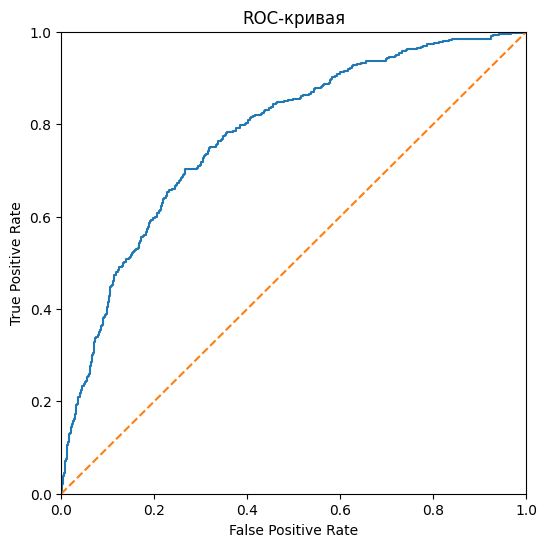

In [42]:
log_model = LogisticRegression(random_state = 88, solver = 'liblinear')
log_model.fit(features_downsampled, target_downsampled)
predicted_valid = log_model.predict(features_valid)
print("F1 мера:", f1_score(target_valid, predicted_valid))

roc_auc(log_model, features_valid, target_valid)

#### Дерево решений

In [43]:
%time

best_depth = 0
best_result = 0
for depth in range(1, 31):
    new_tree_model = DecisionTreeClassifier(random_state = 88, max_depth = depth, criterion = 'gini')
    new_tree_model.fit(features_downsampled, target_downsampled)
    predictions = new_tree_model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    print('Глубина дерева', depth,'F1-мера', result)
    if result > best_result:
        best_depth = depth
        best_result = result


print("F1-мера:", best_result, "Глубина дерева:", best_depth)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Глубина дерева 1 F1-мера 0.48170731707317077
Глубина дерева 2 F1-мера 0.5004965243296922
Глубина дерева 3 F1-мера 0.5225603357817419
Глубина дерева 4 F1-мера 0.5136251032204789
Глубина дерева 5 F1-мера 0.5641025641025641
Глубина дерева 6 F1-мера 0.5551601423487544
Глубина дерева 7 F1-мера 0.5553435114503817
Глубина дерева 8 F1-мера 0.5358490566037737
Глубина дерева 9 F1-мера 0.5102954341987466
Глубина дерева 10 F1-мера 0.4991150442477876
Глубина дерева 11 F1-мера 0.4955908289241623
Глубина дерева 12 F1-мера 0.48586572438162545
Глубина дерева 13 F1-мера 0.4854881266490765
Глубина дерева 14 F1-мера 0.4713919726729291
Глубина дерева 15 F1-мера 0.4728213977566868
Глубина дерева 16 F1-мера 0.4702842377260982
Глубина дерева 17 F1-мера 0.4612765957446809
Глубина дерева 18 F1-мера 0.4600858369098712
Глубина дерева 19 F1-мера 0.4741744284504657
Глубина дерева 20 F1-мера 0.4631217838765008
Глубина дерева 21 F1-мера 0.468988954970263

AUC-ROC: 0.832475


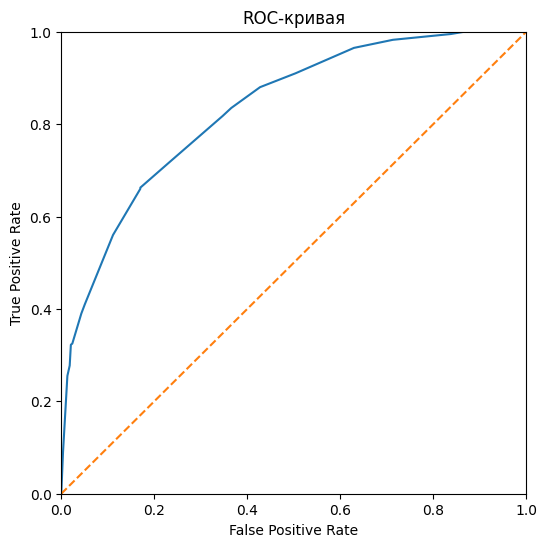

In [44]:
tree_model = DecisionTreeClassifier(random_state = 88, max_depth = 5, criterion = 'gini')
tree_model.fit(features_downsampled, target_downsampled)
predictions = tree_model.predict(features_valid)

roc_auc(tree_model, features_valid, target_valid)

#### Случайный лес

In [45]:
%%time

best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 151, 10):
    for depth in range (1, 21):
        new_forest_model = RandomForestClassifier(random_state = 88, max_depth = depth, criterion = 'gini', n_estimators = est)
        new_forest_model.fit(features_downsampled, target_downsampled)
        predictions = new_forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        print('Количество деревьев', est, 'Глубина', depth, 'F1-мера', result)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print("F1-мера:", best_result, "Количество деревьев:", best_est, "При глубине каждого дерева:", best_depth)


Количество деревьев 10 Глубина 1 F1-мера 0.5122349102773246
Количество деревьев 10 Глубина 2 F1-мера 0.5349952061361457
Количество деревьев 10 Глубина 3 F1-мера 0.5380434782608696
Количество деревьев 10 Глубина 4 F1-мера 0.5520926090828139
Количество деревьев 10 Глубина 5 F1-мера 0.5730550284629982
Количество деревьев 10 Глубина 6 F1-мера 0.5752380952380952
Количество деревьев 10 Глубина 7 F1-мера 0.5663551401869159
Количество деревьев 10 Глубина 8 F1-мера 0.5580524344569288
Количество деревьев 10 Глубина 9 F1-мера 0.5592417061611374
Количество деревьев 10 Глубина 10 F1-мера 0.5512820512820513
Количество деревьев 10 Глубина 11 F1-мера 0.5499058380414312
Количество деревьев 10 Глубина 12 F1-мера 0.5463137996219282
Количество деревьев 10 Глубина 13 F1-мера 0.5203703703703704
Количество деревьев 10 Глубина 14 F1-мера 0.5394112060778727
Количество деревьев 10 Глубина 15 F1-мера 0.5330776605944391
Количество деревьев 10 Глубина 16 F1-мера 0.5445641527913809
Количество деревьев 10 Глубина 17

AUC-ROC: 0.8570492187500001


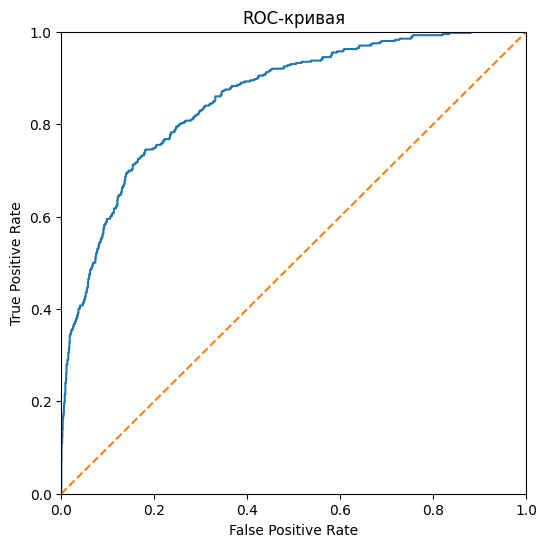

In [46]:
forest_model = RandomForestClassifier(random_state = 88, max_depth = 5, criterion = 'gini', n_estimators = 40)
forest_model.fit(features_downsampled, target_downsampled)
predictions = forest_model.predict(features_valid)

roc_auc(forest_model, features_valid, target_valid)

Наилучшая модель по метрикам - RandomForest с апсемплингом и взвешиванием классов

### Объединенный способ

In [47]:
%%time

best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 151, 10):
    for depth in range (1, 21):
        new_forest_model = RandomForestClassifier(random_state = 88, max_depth = depth, criterion = 'gini', n_estimators = est, class_weight = 'balanced')
        new_forest_model.fit(features_upsampled, target_upsampled)
        predictions = new_forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        print('Количество деревьев', est, 'Глубина', depth, 'F1-мера', result)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print("F1-мера:", best_result, "Количество деревьев:", best_est, "При глубине каждого дерева:", best_depth)

Количество деревьев 10 Глубина 1 F1-мера 0.5138121546961326
Количество деревьев 10 Глубина 2 F1-мера 0.5261044176706827
Количество деревьев 10 Глубина 3 F1-мера 0.5419766206163656
Количество деревьев 10 Глубина 4 F1-мера 0.5779543197616683
Количество деревьев 10 Глубина 5 F1-мера 0.5714285714285713
Количество деревьев 10 Глубина 6 F1-мера 0.5729386892177589
Количество деревьев 10 Глубина 7 F1-мера 0.5930599369085174
Количество деревьев 10 Глубина 8 F1-мера 0.5985247629083246
Количество деревьев 10 Глубина 9 F1-мера 0.5820895522388061
Количество деревьев 10 Глубина 10 F1-мера 0.5867861142217244
Количество деревьев 10 Глубина 11 F1-мера 0.5636363636363637
Количество деревьев 10 Глубина 12 F1-мера 0.5846867749419954
Количество деревьев 10 Глубина 13 F1-мера 0.5745721271393643
Количество деревьев 10 Глубина 14 F1-мера 0.55819774718398
Количество деревьев 10 Глубина 15 F1-мера 0.5442708333333334
Количество деревьев 10 Глубина 16 F1-мера 0.5596816976127321
Количество деревьев 10 Глубина 17 F

## Тестирование модели

In [48]:
new_features_train = pd.concat([features_train, features_valid])
new_target_train = pd.concat([target_train, target_valid])

In [49]:
new_features_train_us, new_target_train_us = upsample(new_features_train, new_target_train, 4)

AUC-ROC: 0.8546399287323005


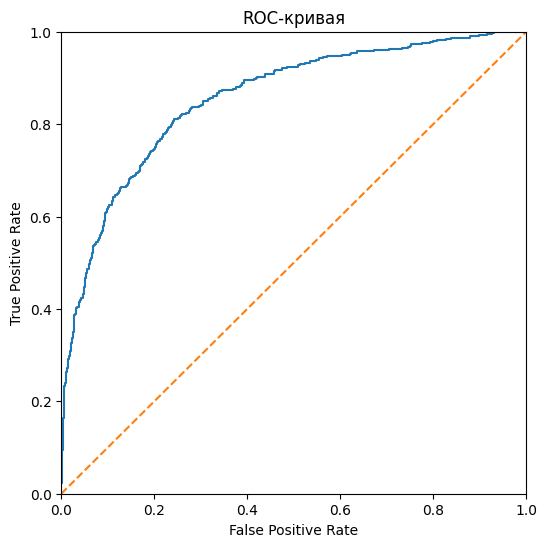

0.5959821428571428


In [50]:
forest_model = RandomForestClassifier(random_state = 88, max_depth = 8, criterion = 'gini', n_estimators = 130, class_weight = 'balanced')
forest_model.fit(new_features_train, new_target_train)
predictions = forest_model.predict(features_test)

roc_auc(forest_model, features_test, target_test)
print(f1_score(target_test, predictions))

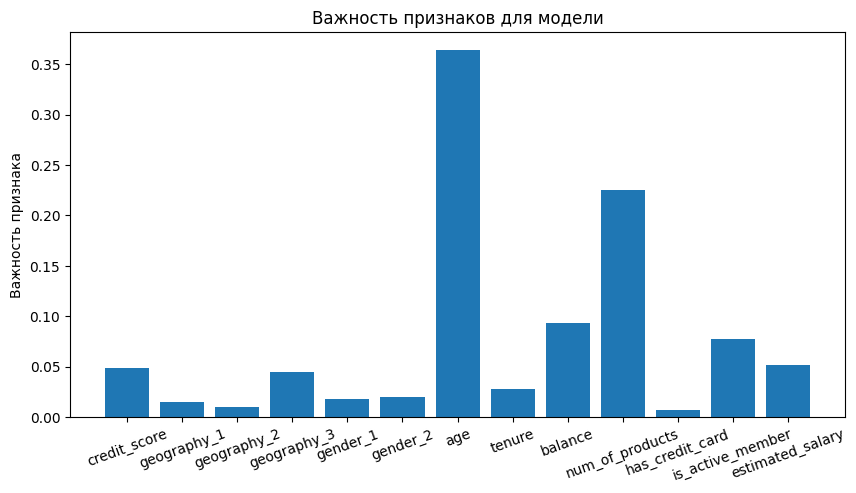

In [51]:
plt.figure(figsize = (10, 5))
plt.bar(features_test.columns, forest_model.feature_importances_)
plt.xticks(rotation = 20)
plt.ylabel("Важность признака")
plt.title("Важность признаков для модели")
plt.show()

## Вывод

Провели начальных анализ данных, были устранены пропуски в столбце Tenure, дубликатов не выявленно. Категориальные значения были закодированы методом OHE, прочие данные отмасштабированны.

Первые построенные модели имели низкую точность предсказаний. Был выявлен дисбаланс классов 1/4 (20%/80%), для его устранения использовали методы взвешивания классов, увеличения и уменьшения выборки.

Наиболее важными признаками оказались возраст клиента и количество продуктов банка используемых им.

Наилучшей моделью явлется Random Forest с апсемплингом и взвешиванием классов с F1-мерой 0.59 и с долей истинно верных  ответов 85%.